In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

from dagmm import DAGMM

from scipy.special import logsumexp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="3"

/media/project_workspace/baiyong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cnv_data_dir = '../cnv_data/'

win_size = 10000
bin_size_overlap = 20
model = 'dense'

model_dir = './ws'+str(win_size)+'_bins'+str(bin_size_overlap)+'_multisample_15cov_'+model

In [3]:
sample_id_arr = np.loadtxt(os.path.join(cnv_data_dir,'sample.list'), 
                        delimiter='\t',usecols=(0,1),dtype='str')

sample_id_dict=dict(zip(sample_id_arr[:,1],sample_id_arr[:,0]))

In [4]:

#  0: DUP, 1: NEU, 2: DEL

# model_dagmm = DAGMM(
#     comp_hiddens=[32,16,1], comp_activation=tf.nn.tanh, # 16
#     est_hiddens=[8,6], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
#     epoch_size=100, minibatch_size=1024,normalize=False #1000
# )
model_dagmm = DAGMM(
    comp_hiddens=[32,16,1], comp_activation=tf.nn.tanh, # 16
    est_hiddens=[8,16,3], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=100, minibatch_size=1024,normalize=False #1000
)
model_dagmm.restore(model_dir)

INFO:tensorflow:Restoring parameters from ./ws10000_bins20_multisample_15cov_dense/DAGMM_model


In [5]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


In [6]:
colors={0:'r', 1:'g', 2: 'b', 3:'k',4:'m',5:'c',6:'y'}
legends={0:'DUP', 1: 'NEU', 2: 'DEL', 3:'DUP/DEL'}

In [7]:
# only for somactic DNA
chrs = ['chr'+str(i) for i in range(1,23)]

# test sample id
iddss=['ERR022452_1','ERR055335_1',
       'ERR055337_1','SRR023302_1',
       'SRR030606_1','SRR359301_1',
       'SRR359301_1','SRR389620_1',
      'SRR580982_1']
# NA12878 SRR098401_1
idd = iddss[2] #6
sampleId = sample_id_dict[idd]
test_fname = '15coverage_ws10000_ratio/'+idd+'.sorted.rmdup.realign.BQSR.bam.'+sampleId+'_winsize_10000.correct_ratio.txt'
test_df =pd.read_csv(os.path.join(cnv_data_dir,test_fname), sep='\t')


In [8]:

ws = bin_size_overlap
# cy_ratio_mat=[]
pred_chrms={}
for chrn in chrs:
    
    chr_df = test_df[(test_df['space']==chrn) & (test_df['copy'])].sort_values(by=['start'])
    i_copy = chr_df['copy'].values
    start_pos=chr_df['start'].values
    end_pos=chr_df['end'].values
    reads = chr_df['reads'].values
    gcs = chr_df['gc'].values
    mapps = chr_df['map'].values
    # add 0 at the beginning of sequence
    tmp_copy = np.append([0]*(ws-1),i_copy)
    i_cy_matrix= rolling_window(tmp_copy,ws)   
#     if len(cy_ratio_mat) == 0:
#         cy_ratio_mat = i_cy_matrix
#     else:
#         cy_ratio_mat = np.concatenate((cy_ratio_mat,i_cy_matrix),axis=0)

    energy,logit_probs = model_dagmm.predict(i_cy_matrix)
    lse = logsumexp(logit_probs,axis=0)
    log_resp=logit_probs-lse[np.newaxis,:]
    comp_prob = np.exp(log_resp)
    i_comp=np.argmax(comp_prob,axis=0)
    
    
    
    d={'start':start_pos,'end':end_pos,'pred':i_comp,'copy':i_copy,'gc':gcs,'reads':reads,'maps':mapps}
    pred_chrms[chrn] = pd.DataFrame(data=d)


In [9]:
# 'HG01136'
cnvs_annos = pd.read_csv(os.path.join(cnv_data_dir,'ALL.wgs.mergedSV.v8.20130502.svs.genotypes.GRCh38.vcf.cnvs.dat'),
           sep='\t',usecols=['CHROM', 'POS', 'ID', 'ALT', 'SVTYPE',
       'SVLEN', 'END','AF', 'SUPP_N_HET','SUPP_N_HOM_ALT','SUPP_HETS','SUPP_HOM_ALTS'])

test_cnvs = cnvs_annos[cnvs_annos['SUPP_HETS'].str.contains(sampleId) 
                       | cnvs_annos['SUPP_HOM_ALTS'].str.contains(sampleId)]

test_cnvs.sort_values(by=['CHROM','POS'],inplace=True)
test_cnvs.reset_index(drop=True, inplace=True)


adjstart = np.floor(test_cnvs['POS'].values*1.0/win_size) * win_size+1
adjstart = adjstart.astype('int')
test_cnvs['ADJPOS']= adjstart
adjend = np.ceil(test_cnvs['END'].values*1.0/win_size) * win_size
adjend = adjend.astype('int')
test_cnvs['ADJEND'] = adjend
test_cnvs['NWIN']=(test_cnvs['ADJEND']-test_cnvs['ADJPOS']+1)//win_size 
test_cnvs['ADJTYPE']=test_cnvs['SVTYPE']
test_cnvs.loc[(test_cnvs['SVTYPE']=='CNV') & ( ~test_cnvs['ALT'].str.contains('CN0')),'ADJTYPE']='DUP'
re_str = '('+sampleId+',[0-9]\|[0-9])'
test_cnvs['TARGET_HET_GT']=test_cnvs['SUPP_HETS'].str.extract(re_str).str.strip() 
test_cnvs['TARGET_HOM_GT']=test_cnvs['SUPP_HOM_ALTS'].str.extract(re_str).str.strip()
test_cnvs = test_cnvs[['CHROM','POS','ID','ALT','ADJTYPE','END','SVLEN','AF','ADJPOS','ADJEND','NWIN','TARGET_HET_GT','TARGET_HOM_GT']]


/media/project_workspace/baiyong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/media/project_workspace/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/media/project_workspace/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel i

In [10]:
tru_chr1_cnvs = test_cnvs[test_cnvs['CHROM']==1]
pred_chr1_cnv=pred_chrms['chr1']
pred_chr1_cnv['truth']='NEU'
pred_chr1_cnv['ID']=''
pred_chr1_cnv['svlen']=0
pred_chr1_cnv['POS']=0
pred_chr1_cnv['END']=0
pred_chr1_cnv['TARGET_HET_GT']=''
pred_chr1_cnv['TARGET_HOM_GT']=''


for i,x in tru_chr1_cnvs.iterrows():
    pred_chr1_cnv.loc[(pred_chr1_cnv['start']>=x['ADJPOS']) & (pred_chr1_cnv['end']<=x['ADJEND']),'truth'] = x['ADJTYPE']
    pred_chr1_cnv.loc[(pred_chr1_cnv['start']>=x['ADJPOS']) & (pred_chr1_cnv['end']<=x['ADJEND']),'ID'] = x['ID']
    pred_chr1_cnv.loc[(pred_chr1_cnv['start']>=x['ADJPOS']) & (pred_chr1_cnv['end']<=x['ADJEND']),'svlen'] = int(x['SVLEN'])
    pred_chr1_cnv.loc[(pred_chr1_cnv['start']>=x['ADJPOS']) & (pred_chr1_cnv['end']<=x['ADJEND']),'AF'] = x['AF']
    pred_chr1_cnv.loc[(pred_chr1_cnv['start']>=x['ADJPOS']) & (pred_chr1_cnv['end']<=x['ADJEND']),'POS'] = x['POS']
    pred_chr1_cnv.loc[(pred_chr1_cnv['start']>=x['ADJPOS']) & (pred_chr1_cnv['end']<=x['ADJEND']),'END'] = int(x['END'])
    pred_chr1_cnv.loc[(pred_chr1_cnv['start']>=x['ADJPOS']) & (pred_chr1_cnv['end']<=x['ADJEND']),'TARGET_HET_GT'] = x['TARGET_HET_GT']
    pred_chr1_cnv.loc[(pred_chr1_cnv['start']>=x['ADJPOS']) & (pred_chr1_cnv['end']<=x['ADJEND']),'TARGET_HOM_GT'] = x['TARGET_HOM_GT']
    

In [11]:
# hard-code to genotyping
# 0: DUP, 1: NEU, 2: DEL, 3 DUP/DEL
pred_chr1_cnv['gt_pred'] = 1
pred_chr1_cnv.loc[(pred_chr1_cnv['pred']!=1) & (pred_chr1_cnv['copy']<0),'gt_pred']=2
pred_chr1_cnv.loc[(pred_chr1_cnv['pred']!=1) & (pred_chr1_cnv['copy']>0),'gt_pred']=0
pred_chr1_cnv.loc[(pred_chr1_cnv['pred']!=1) & (pred_chr1_cnv['truth']=='CNV'),'gt_pred']=3

pred_chr1_cnv['gt_truth'] = 1
pred_chr1_cnv.loc[(pred_chr1_cnv['truth']=='DUP') ,'gt_truth']=0
pred_chr1_cnv.loc[(pred_chr1_cnv['truth']=='DEL') ,'gt_truth']=2
pred_chr1_cnv.loc[(pred_chr1_cnv['truth']=='CNV') ,'gt_truth']=3


In [12]:
pred_chr1_cnv[(pred_chr1_cnv['gt_truth']==2)]

,copy,end,gc,maps,pred,reads,start,truth,ID,svlen,POS,END,TARGET_HET_GT,TARGET_HOM_GT,AF,gt_pred,gt_truth
85,-0.114759,1160000,0.5990,0.973370,1,561,1150001,DEL,DEL_pindel_12,206,1151437,1151643,"HG02009,0|1",NaN,0.0726837,1,2
297,0.153844,3580000,0.6152,0.963712,1,662,3570001,DEL,DEL_pindel_116,57,3571709,3571766,"HG02009,0|1",NaN,0.0636981,1,2
354,0.165321,4150000,0.4935,0.985754,1,759,4140001,DEL,DEL_pindel_129,50,4144607,4144657,"HG02009,0|1",NaN,0.485623,1,2
876,-0.158236,9370000,0.5497,0.995576,1,584,9360001,DEL,DEL_pindel_216,74,9366221,9366295,"HG02009,0|1",NaN,0.00019968,1,2
893,-0.514091,9540000,0.4988,0.945768,1,465,9530001,DEL,YL_CN_GBR_48,2509,9535301,9537810,NaN,"HG02009,1|1",0.219249,1,2
982,-0.376630,10430000,0.5052,0.846747,1,515,10420001,DEL,UW_VH_0,1291,10422442,10423733,NaN,"HG02009,1|1",0.329273,1,2
1516,-0.482993,15830000,0.4820,0.960185,1,483,15820001,DEL,YL_CN_FIN_64,3950,15825187,15829137,"HG02009,1|0",NaN,0.23742,1,2
1890,-0.067256,19630000,0.4448,0.980411,1,674,19620001,DEL,DEL_pindel_329,66,19628383,19628449,NaN,"HG02009,1|1",0.225639,1,2
2073,-0.045870,21460000,0.4125,0.745783,1,703,21450001,DEL,BI_GS_DEL1_B3_P0022_20,277,21459925,21460202,"HG02009,1|0",NaN,0.713858,1,2
2074,0.133644,21470000,0.4186,0.641653,1,792,21460001,DEL,BI_GS_DEL1_B3_P0022_20,277,21459925,21460202,"HG02009,1|0",NaN,0.713858,1,2


Text(0.5,0,'log2 ratio')

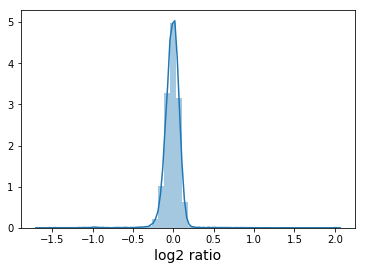

In [13]:
neu_pred_df = pred_chr1_cnv[(pred_chr1_cnv['gt_pred']==1) & (pred_chr1_cnv['gt_truth']==1)]
#false_pred_copys - flase_pred_df['copy'].values

neu_pred_df =  neu_pred_df['copy'].values

sns.distplot(neu_pred_df, kde=True)
plt.xlabel('log2 ratio', fontsize=14)

In [14]:
np.mean(neu_pred_df)-2*np.std(neu_pred_df),np.mean(neu_pred_df)+2*np.std(neu_pred_df)

(-0.257567530584511, 0.22583860573830877)

Text(0.5,0,'log2 ratio')

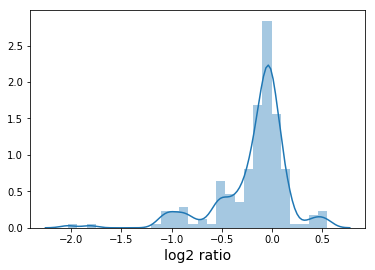

In [15]:
false_pred_df = pred_chr1_cnv[(pred_chr1_cnv['gt_pred']==1) & (pred_chr1_cnv['gt_truth']!=1)]
#false_pred_copys - flase_pred_df['copy'].values

false_pred_copy =  false_pred_df['copy'].values

sns.distplot(false_pred_copy, kde=True)
plt.xlabel('log2 ratio', fontsize=14)

In [17]:
i_false_count = false_pred_copy[(np.mean(neu_pred_df)-2*np.std(neu_pred_df)<false_pred_copy) 
                                & (false_pred_copy<np.mean(neu_pred_df)+2*np.std(neu_pred_df))]
len(i_false_count)*1.0/len(false_pred_copy)

0.6951871657754011

[[Text(0,0,'DEL'), Text(0,0,'DUP'), Text(0,0,'DUP/DEL')]]

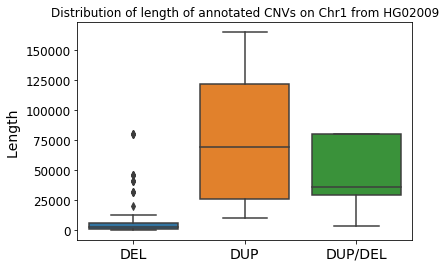

In [18]:



ax = sns.boxplot(x='truth', y='svlen', data=pred_chr1_cnv[pred_chr1_cnv['truth']!='NEU'])
plt.yticks(fontsize=12)
plt.xticks(fontsize=14)
plt.xlabel('')
plt.ylabel('Length ',fontsize=14)
plt.title('Distribution of length of annotated CNVs on Chr1 from HG02009')
ax.set(xticklabels=['DEL','DUP','DUP/DEL'])


[[Text(0,0,'DEL'), Text(0,0,'DUP'), Text(0,0,'DUP/DEL')]]

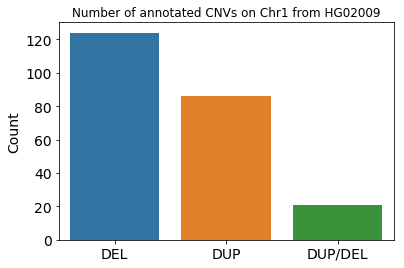

In [19]:
ax = sns.countplot(x="truth", data=pred_chr1_cnv[pred_chr1_cnv['truth']!='NEU'])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('')
plt.ylabel('Count',fontsize=14)
plt.title('Number of annotated CNVs on Chr1 from HG02009')
ax.set(xticklabels=['DEL','DUP','DUP/DEL'])

Text(0.5,1,'HG02009, chr1, window size = 10kbp')

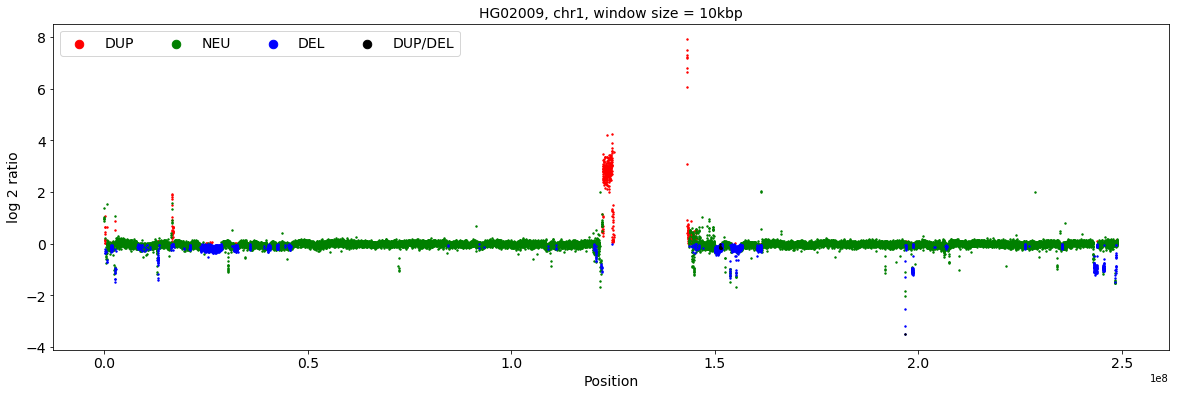

In [183]:
# bins=20



uni_preds = np.unique(pred_chr1_cnv['gt_pred'].values)

color = [colors[x] for x in pred_chr1_cnv['gt_pred'].values]
plt.figure(figsize=(20,6))
for i in uni_preds:
    clr = colors[i]
    partial_cnvs=pred_chr1_cnv[pred_chr1_cnv['gt_pred']==i]
    plt.scatter(partial_cnvs['start'].values,partial_cnvs['copy'].values,c=clr,s=2, label=legends[i])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position',fontsize=14)
plt.ylabel('log 2 ratio',fontsize=14)
plt.legend(frameon=True, loc='upper left', ncol=len(uni_preds), fontsize=14,markerscale=6)
plt.title('HG02009, chr1, window size = 10kbp', fontsize=14)



# plt.axvline(x=exm_dup_start_pt, c='k',alpha=0.3)
# plt.axvline(x=exm_dup_end_pt, c='k',alpha=0.3)
# plt.title('HG01136,chr1',fontsize=14)
#plt.xlim([3190000, 11630000])
#plt.hlines(y=test_cnvs_labs,xmin=test_cnvs_starts,xmax=test_cnvs_ends)

exm_dup_mean_ratio 0.032515601648457675


Text(0.5,1,'chr1:239,970,001-240,140,000 \n ID=DUP_uwash_chr1_240137922_240302859')

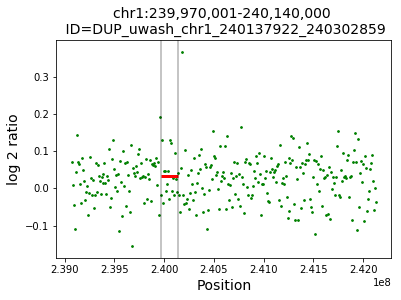

In [35]:
# false negative: DUP_uwash_chr1_240137922_240302859
exm_dup_start_pt = 239970001
exm_dup_end_pt = 240140000


partial_dat_df = pred_chr1_cnv[(pred_chr1_cnv['start']>=239070001) & (pred_chr1_cnv['start']<=242140000)]

exm_dup_mean_ratio = np.mean(pred_chr1_cnv[(pred_chr1_cnv['start']>=exm_dup_start_pt) & (pred_chr1_cnv['end']<=exm_dup_end_pt)]['copy'].values)
print('exm_dup_mean_ratio',exm_dup_mean_ratio)
plt.scatter(partial_dat_df['start'].values,partial_dat_df['copy'].values,c='g',s=3)
plt.hlines(y=exm_dup_mean_ratio, xmin=exm_dup_start_pt, xmax=exm_dup_end_pt, color='r', linewidth=3)
plt.axvline(x=exm_dup_start_pt, c='k',alpha=0.3)
plt.axvline(x=exm_dup_end_pt, c='k',alpha=0.3)
plt.xlabel('Position',fontsize=14)
plt.ylabel('log 2 ratio',fontsize=14)
plt.title('chr1:239,970,001-240,140,000 \n ID=DUP_uwash_chr1_240137922_240302859', fontsize=14)


exm_dup_mean_ratio -0.7685753820498046


Text(0.5,1,'chr1:239,970,001-240,140,000 \n ID=DUP_uwash_chr1_240137922_240302859')

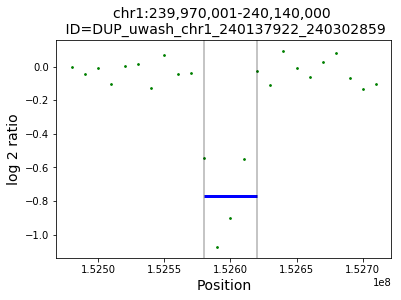

In [55]:
# false negative: DUP_uwash_chr1_240137922_240302859
exm_del_start_pt1 = 152580001 #120950001
exm_del_end_pt1 = 152620000


partial_dat_df = pred_chr1_cnv[(pred_chr1_cnv['start']>=152480001) & (pred_chr1_cnv['start']<=152720000)]


exm_del_mean_ratio = np.mean(pred_chr1_cnv[(pred_chr1_cnv['start']>=exm_del_start_pt1) & (pred_chr1_cnv['end']<=exm_del_end_pt1)]['copy'].values)
print('exm_dup_mean_ratio',exm_del_mean_ratio)
plt.scatter(partial_dat_df['start'].values,partial_dat_df['copy'].values,c='g',s=3)
plt.hlines(y=exm_del_mean_ratio, xmin=exm_del_start_pt1, xmax=exm_del_end_pt1, color='b', linewidth=3)
plt.axvline(x=exm_del_start_pt1, c='k',alpha=0.3)
plt.axvline(x=exm_del_end_pt1, c='k',alpha=0.3)
plt.xlabel('Position',fontsize=14)
plt.ylabel('log 2 ratio',fontsize=14)
plt.title('chr1:152,580,001-152,620,000 \n ID=BI_GS_CNV_1_152555495_152586932', fontsize=14)

In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas_ml import ConfusionMatrix
from sklearn.utils.multiclass import unique_labels

In [95]:
#  calculate 
def get_cls_reports(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    
    # Precision or positive predictive value
    PPV = TP/(TP+FP)

    # Negative predictive value
    NPV = TN/(TN+FN)

    # Fall out or false positive rate
    FPR = FP/(FP+TN)

    # False negative rate or Miss Rate
    FNR = FN/(TP+FN)
    
    # False discovery rate
    FDR = FP/(TP+FP)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return (TPR, TNR, PPV,NPV,FPR,FNR,FDR,ACC)

In [ ]:
def get_cls_reports2(y_true,y_pred,target_labs = [0,2,3]):
    # for 
    

In [96]:

cnv_size=[500,1000,5000,10000,20000,60000]
TPR_lst=[];
FDR_lst=[]
for i_cnv_size in cnv_size:
    tmp_only_cnvs = pred_chr1_cnv[pred_chr1_cnv['svlen']>=i_cnv_size]
    (TPR, TNR, PPV,NPV,FPR,FNR,FDR,ACC) = get_cls_reports(tem_df['gt_truth'].values,
                                                          tem_df['gt_pred'].values)

    TPR_lst.append(TPR)
    FDR_lst.append(FDR)
#specificity = tn / (tn+fp)

In [97]:
TPR_lst

[array([0.27, 0.91, 0.09, 0.48]),
 array([0.27, 0.91, 0.12, 0.48]),
 array([0.27, 0.91, 0.14, 0.53]),
 array([0.27, 0.91, 0.13, 0.56]),
 array([0.28, 0.91, 0.18, 0.62]),
 array([0.29, 0.91, 0.75, 1.  ])]

In [98]:
FDR_lst

[array([0.95, 0.01, 0.99, 0.  ]),
 array([0.95, 0.01, 0.99, 0.  ]),
 array([0.95, 0.  , 1.  , 0.  ]),
 array([0.95, 0.  , 1.  , 0.  ]),
 array([0.96, 0.  , 1.  , 0.  ]),
 array([0.97, 0.  , 1.  , 0.  ])]

In [88]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.27 0.72 0.01 0.  ]
 [0.02 0.91 0.07 0.  ]
 [0.   0.92 0.08 0.  ]
 [0.   0.52 0.   0.48]]
Confusion Matrix:

Predicted    0      1     2   3  __all__
Actual                                  
0           23     62     1   0       86
1          440  20687  1585   0    22712
2            0    114    10   0      124
3            0     11     0  10       21
__all__    463  20874  1596  10    22943


Overall Statistics:

Accuracy: 0.9035435644858998
95% CI: (0.8996504867866881, 0.9073340644231542)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.9995160489953606
Kappa: 0.024593573603564536
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                         0           1            2  \
Population                                  22943       22943        22943   
P: Condition positive                          86       22712          124   
N: Condition negative                       22857         231        22819   
Test outcome pos

/media/project_workspace/baiyong/anaconda3/lib/python3.6/site-packages/pandas_ml/confusion_matrix/bcm.py:330: RuntimeWarning: divide by zero encountered in double_scalars
  return(np.float64(self.TPR) / self.FPR)


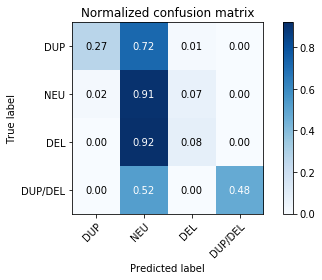

In [89]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
class_names=np.array(['DUP','NEU','DEL','DUP/DEL'])

y_true = pred_chr1_cnv['gt_truth'].values
y_pred = pred_chr1_cnv['gt_pred'].values
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,title='Normalized confusion matrix')

from pandas_ml import ConfusionMatrix
# from pycm import ConfusionMatrix
confusion_matrix = ConfusionMatrix(y_true, y_pred)
confusion_matrix.print_stats()